In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

BATCH_SIZE = 4
EPOCHS = 10

cuda


In [2]:
transform = transforms.Compose(
    [transforms.Resize((224,224)),
    transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)


# Data Load
image_dataset = torchvision.datasets.ImageFolder(root="/home/iai/Desktop/Jeewon/Seminar/20230112_MVtecAD/data/simpleclassification_good_bad_aug/dataset", transform = transform)
print(f'Entire classes : {image_dataset.classes}')
print(f'Size of Entire classes : {len(image_dataset)}')

Entire classes : ['bad', 'good']
Size of Entire classes : 8192


In [3]:
train_size = int(0.8 * len(image_dataset))
test_size = len(image_dataset) - train_size

train_dataset, test_dataset = random_split(image_dataset, [train_size, test_size])


print(f'Size of entire dataset : {len(image_dataset)}')
print(f'Size of train dataset : {len(train_dataset)}')
print(f'Size of train dataset : {len(test_dataset)}')

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers=2)


def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

Size of entire dataset : 8192
Size of train dataset : 6553
Size of train dataset : 1639


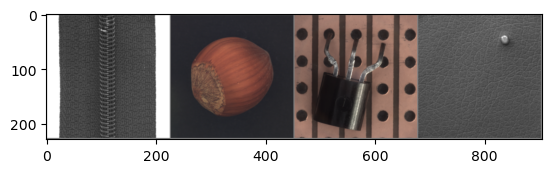

torch.Size([4, 3, 224, 224])


In [4]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(images.shape)

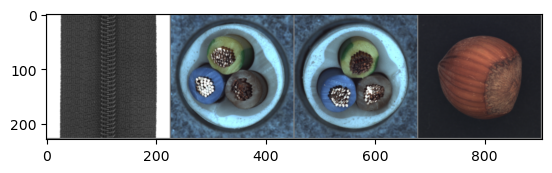

torch.Size([4, 3, 224, 224])


In [5]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(images.shape)

In [6]:
criterion = nn.CrossEntropyLoss()

loss_list = []

def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())

        
        if batch_idx % 500 == 0:
            print("Train Epoch: {} [{}({:.0f}%)]\tTrain Loss : {:.6f}".format(
                EPOCHS, batch_idx * len(image), 100. * batch_idx / len(train_loader), loss.item()
            ))

In [7]:
acc_list = []
accuracy = 0.0

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    
    with torch.no_grad():
      n_correct = 0
      n_samples = 0
      n_class_correct = [0 for i in range(2)]
      n_class_samples = [0 for i in range(2)]
      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          output = model(images)
          test_loss += criterion(output, labels).item()
          _, predicted = torch.max(output,1)
          n_samples += labels.size(0)
          n_correct += (predicted == labels).sum().item()
          
          for i in range(2):
            label = labels[i]
            pred = predicted[i]
            if(label == pred):
              n_class_correct[label]+=1
            n_class_samples[label]+=1
          acc_list.append(n_correct/n_samples * 100.)
            

          
    test_loss /= len(test_loader)
    test_accuracy = (n_correct / n_samples) * 100.
    return test_loss, test_accuracy

In [8]:
model = models.vgg16(pretrained = True)
model.classifier[6] = nn.Linear(4096,2)
moodel = model.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/iai/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100.0%


In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
# print(model)

In [10]:
for EPOCH in range(EPOCHS):
    train(model, train_loader, optimizer, log_interval = 5)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.4f} %\n".format(EPOCH+1, test_loss, test_accuracy))

Train Epoch: 10 [0(0%)]	Train Loss : 0.823477
Train Epoch: 10 [2000(31%)]	Train Loss : 0.613885
Train Epoch: 10 [4000(61%)]	Train Loss : 0.708207
Train Epoch: 10 [6000(92%)]	Train Loss : 0.688487

[EPOCH: 1], 	Test Loss: 0.6861, 	Test Accuracy: 58.5723 %

Train Epoch: 10 [0(0%)]	Train Loss : 0.639869
Train Epoch: 10 [2000(31%)]	Train Loss : 0.758138
Train Epoch: 10 [4000(61%)]	Train Loss : 0.730299
Train Epoch: 10 [6000(92%)]	Train Loss : 0.473479

[EPOCH: 2], 	Test Loss: 0.6345, 	Test Accuracy: 62.1721 %

Train Epoch: 10 [0(0%)]	Train Loss : 0.740081
Train Epoch: 10 [2000(31%)]	Train Loss : 0.249545
Train Epoch: 10 [4000(61%)]	Train Loss : 0.564287
Train Epoch: 10 [6000(92%)]	Train Loss : 0.466745

[EPOCH: 3], 	Test Loss: 0.5491, 	Test Accuracy: 71.0189 %

Train Epoch: 10 [0(0%)]	Train Loss : 0.149590
Train Epoch: 10 [2000(31%)]	Train Loss : 0.433417
Train Epoch: 10 [4000(61%)]	Train Loss : 0.708360
Train Epoch: 10 [6000(92%)]	Train Loss : 0.614530

[EPOCH: 4], 	Test Loss: 0.5093, 	Te

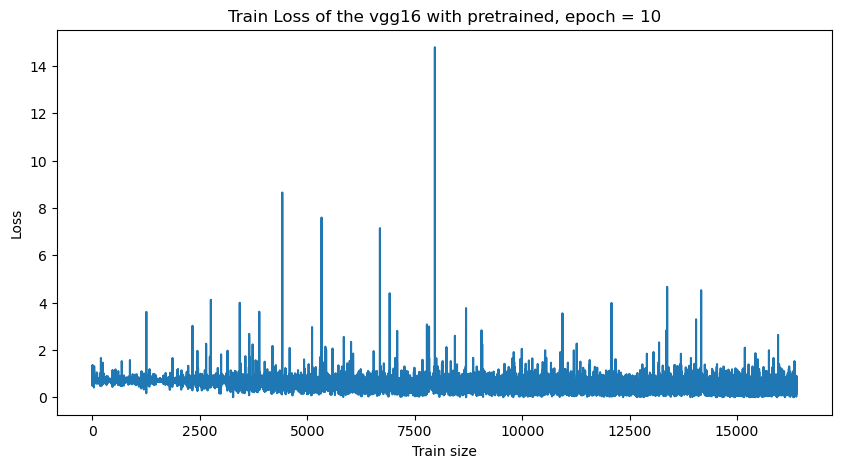

In [11]:
plt.figure(figsize=(10,5))
plt.plot(loss_list)
plt.xlabel('Train size')
plt.ylabel('Loss')
plt.title('Train Loss of the vgg16 with pretrained, epoch = 10')
plt.legend
plt.show()

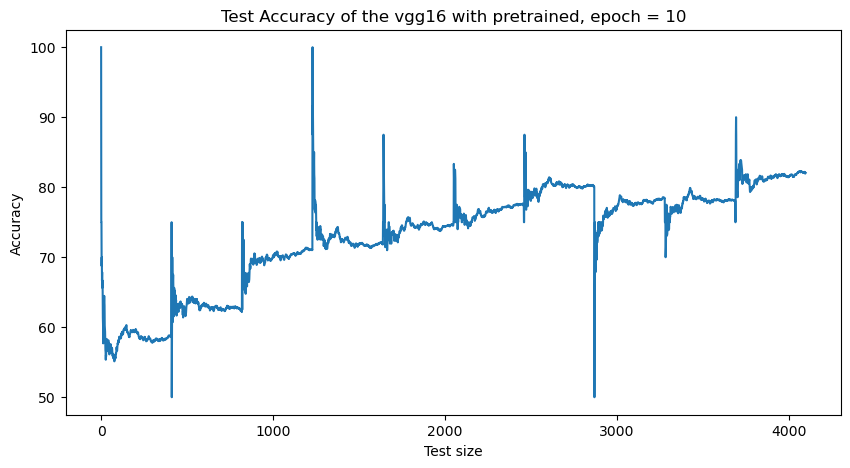

In [12]:
plt.figure(figsize=(10,5))
plt.plot(acc_list)
plt.xlabel('Test size')
plt.ylabel('Accuracy')
plt.title('Test Accuracy of the vgg16 with pretrained, epoch = 10')
plt.legend
plt.show()